## Setup

In [3]:
# libraries
import json
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import pymc as pm
import arviz as az
import numpy as np

/Users/rileymorrison/CAPP/bayes/NSF/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
# open data
with open("grants_df.json", "r") as f:
    grants_raw = json.load(f)
df = pd.DataFrame(grants_raw)

In [18]:
# convert token list to strings for the encoding process
def tokens_to_text(x):
    if isinstance(x, list):
        return " ".join(x)
    elif pd.isna(x):
        return ""
    else:
        return str(x)

df["string_tokenized_abstract"] = df["tokenized_abstract"].apply(tokens_to_text)

In [19]:
# use hugging face model to compute embeddings for each abstract
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")


# Compute embeddings
embeddings = model.encode(
    df["string_tokenized_abstract"].tolist(),
    convert_to_numpy=True,
    show_progress_bar=True
)

# Store embeddings 
df["embedding"] = list(embeddings)
df.to_json("grants_df.json")

Batches: 100%|██████████████████████████████████████| 2571/2571 [35:02<00:00,  1.22it/s]


# Analysis

In [4]:
# load df
with open("grants_df.json", "r") as f:
    grants_raw = json.load(f)
df = pd.DataFrame(grants_raw)

### TF-IDF of leaked banned words

In [5]:
# look at the TF-IDF of banned words over the years
words = [
    "activism",
    "activists",
    "advocacy",
    "advocate",
    "barrier",
    "barriers",
    "biased",
    "bias",
    "bipox",
    "black",
    "latino",
    "latinx",
    "community"
    "diversity",
    "equity",
    "cultural",
    "disabilities",
    "discrimination",
    "discriminatory",
    "backgrounds",
    "diversified",
    "diversify",
    "equal",
    "equality",
    "equitable",
    "ethnicity",
    "excluded",
    "female",
    "fostering",
    "gender",
    "hate",
    "hispanic",
    "historically",
    "implicit bias",
    "inclusion",
    "inclusive",
    "indigenous",
    "inequalities",
    "inequities",
    "institutional",
    "lgbtq",
    "marginalize",
    "minorities",
    "multicultural",
    "polarization",
    "political",
    "prejudice",
    "privileges",
    "promoting",
    "race",
    "racial",
    "justice",
    "sociocultural",
    "socioeconomic",
    "status",
    "stereotypes",
    "systemic",
    "trauma",
    "underappreciated",
    "underrepresented",
    "underserved",
    "victim",
    "women",
]

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# compute TF-IDF restricted to our keywords
vectorizer = TfidfVectorizer(
    vocabulary=words,
    lowercase=True,
    ngram_range=(1, 3),   # allows multi-word phrases like "black and latinx"
)

tfidf_matrix = vectorizer.fit_transform(df["clean_text"])
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=vectorizer.get_feature_names_out()
)

# add years back into the TF-IDF dataframe
tfidf_df["year"] = df["year"].values

# compute per-year mean TF-IDF for each keyword
yearly_tfidf = (
    tfidf_df.groupby("year")[vectorizer.get_feature_names_out()].mean()
)

# get label order
year = 2025   # or max(yearly_tfidf.index)

word_cols = [w for w in yearly_tfidf.columns if w != "dei_index"]

ordered_words = sorted(
    word_cols,
    key=lambda w: yearly_tfidf.loc[year, w],
    reverse=True
)

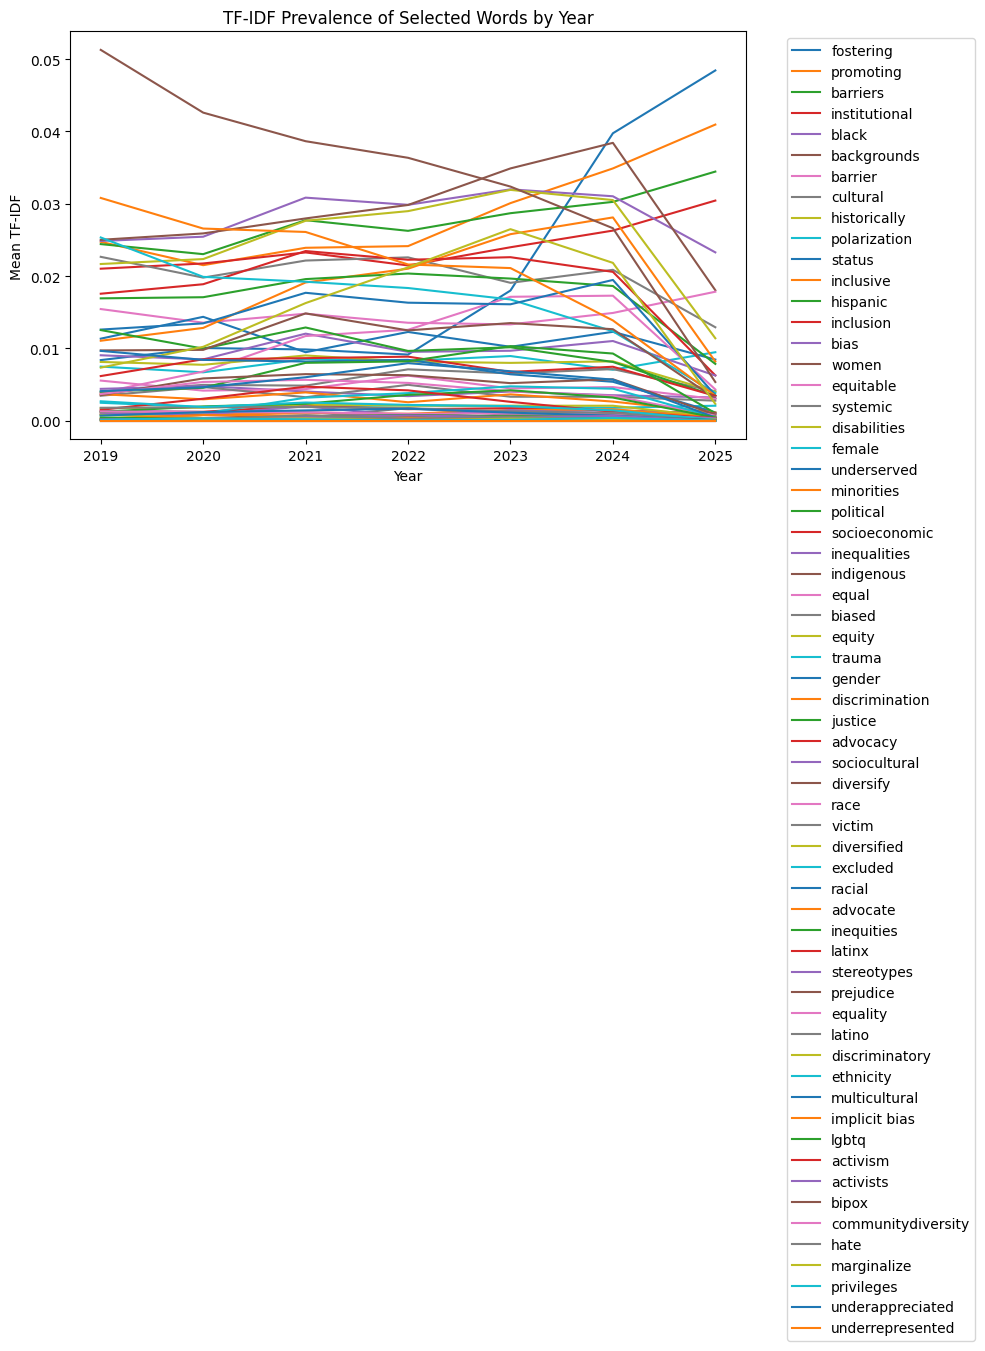

In [7]:
plt.figure(figsize=(10, 10))

years = yearly_tfidf.index

for word in ordered_words:
    plt.plot(years, yearly_tfidf[word], label=word)

plt.title("TF-IDF Prevalence of Selected Words by Year")
plt.xlabel("Year")
plt.ylabel("Mean TF-IDF")

# You can zoom y-axis if needed:
# plt.ylim(0, 0.06)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

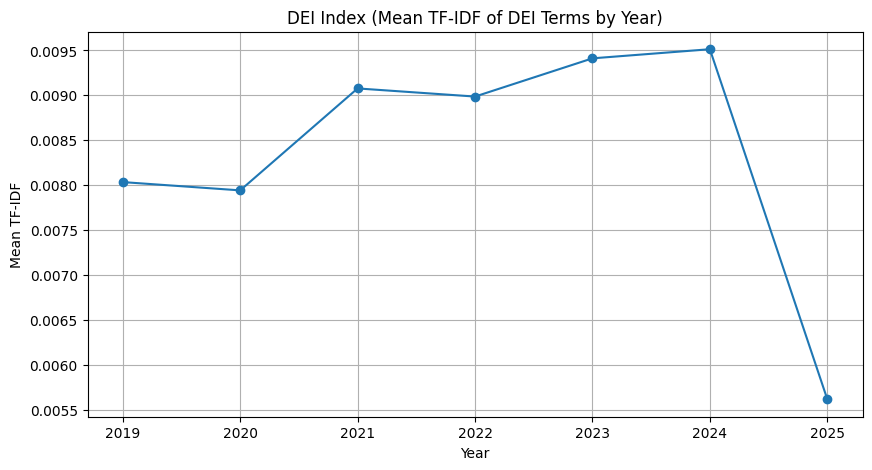

In [8]:
# Mean TF-IDF across all DEI keywords for each year
yearly_tfidf["dei_index"] = yearly_tfidf.mean(axis=1)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(yearly_tfidf.index, yearly_tfidf["dei_index"], marker="o")

plt.title("DEI Index (Mean TF-IDF of DEI Terms by Year)")
plt.xlabel("Year")
plt.ylabel("Mean TF-IDF")
plt.grid(True)
plt.show()

## Semantic Similarity across years using cosine similarity

Divisions with ≥2 years and ≥20 embeddings: ['Advanced Cyberinfrastructure', 'Astronomical Sciences', 'Atmospheric and Geospace Sciences', 'Behavioral and Cognitive Sciences', 'Biological Infrastructure', 'Budget, Finance and Award Management', 'Chemical, Bioengineering, Environmental, and Transport Systems', 'Chemistry', 'Civil, Mechanical and Manufacturing Innovation', 'Computer and Network Systems', 'Computing and Communication Foundations', 'Division of Acquisition and Cooperative Support', 'EPSCoR', 'Earth Sciences', 'Electrical, Communications and Cyber Systems', 'Emerging Frontiers', 'Emerging Frontiers & Multidisciplinary Activities', 'Engineering Education and Centers', 'Environmental Biology', 'Graduate Education', 'Human Resource Management', 'Information & Intelligent Systems', 'Innovation and Technology Ecosystems', 'Integrative Activities', 'Integrative Organismal Systems', 'International Science and Engineering', 'Materials Research', 'Mathematical Sciences', 'Molecular 

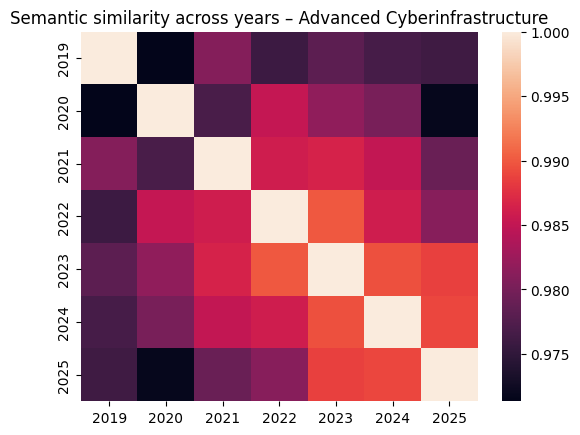

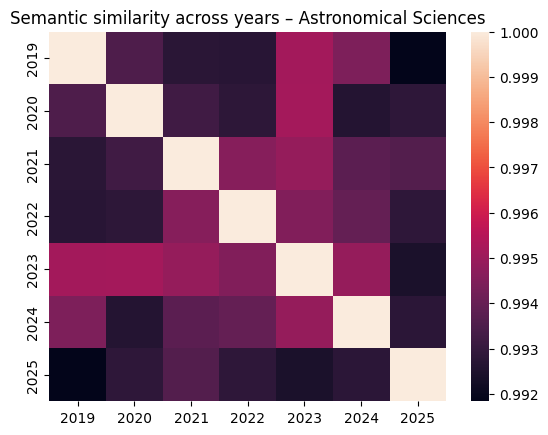

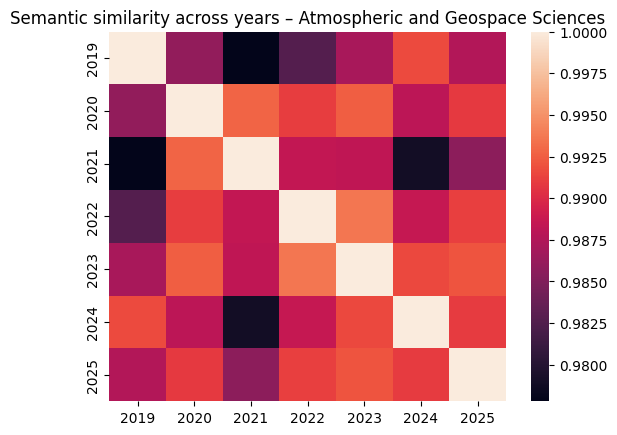

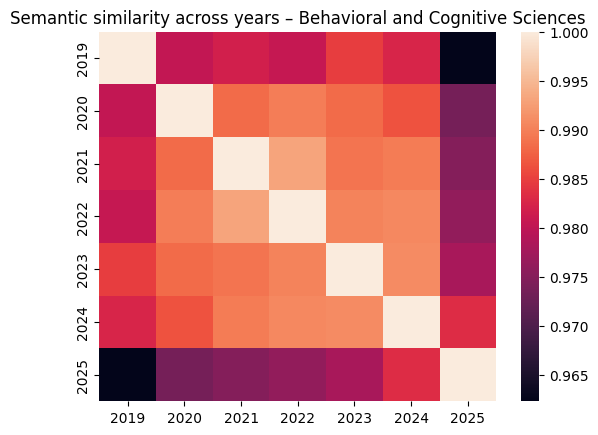

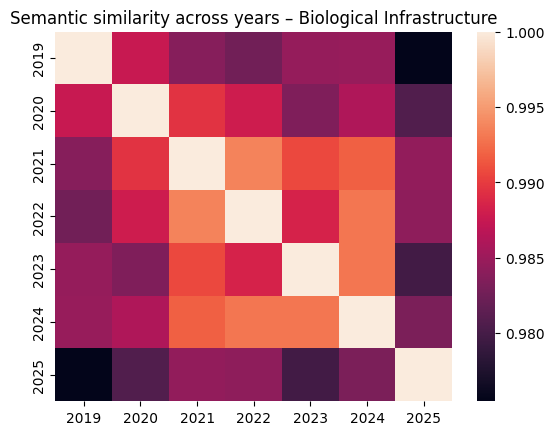

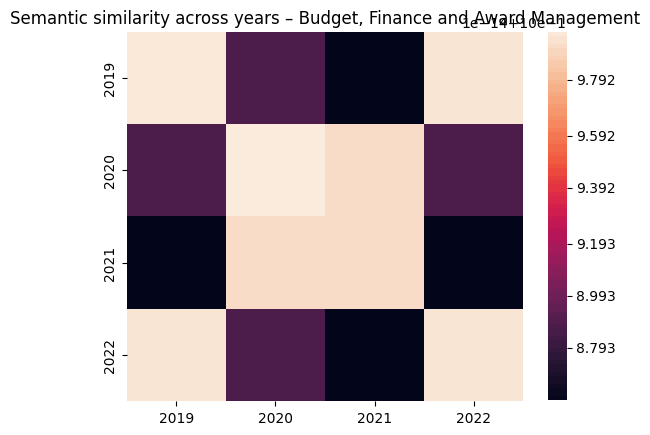

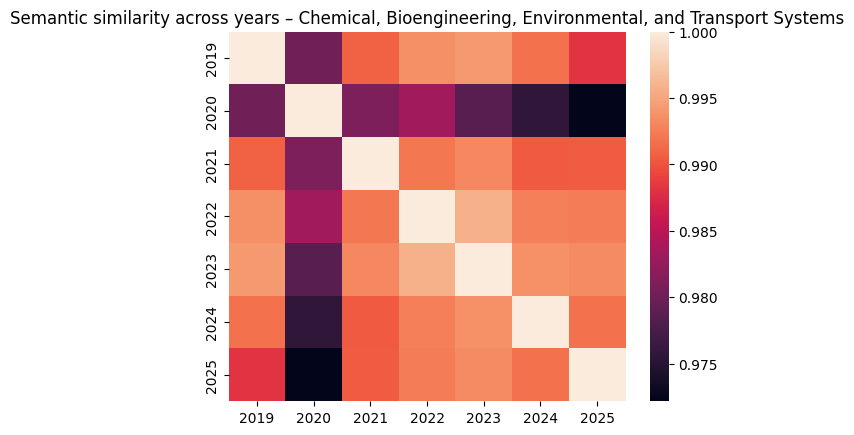

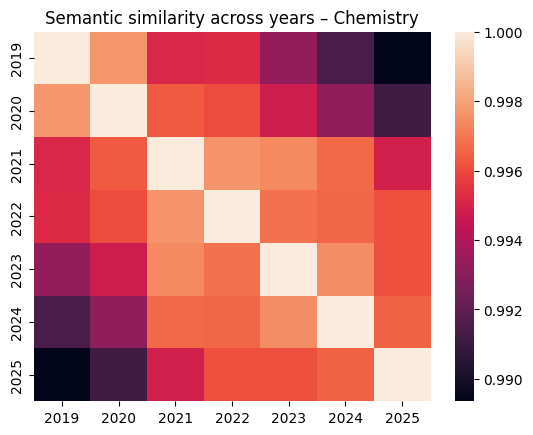

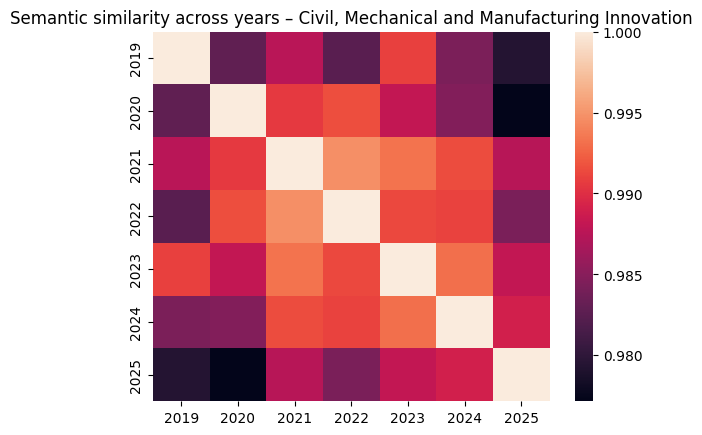

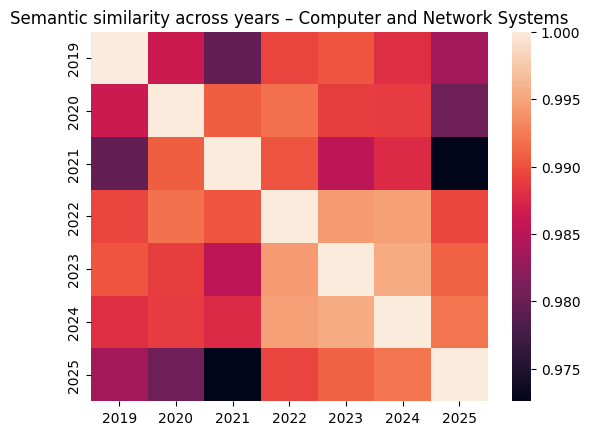

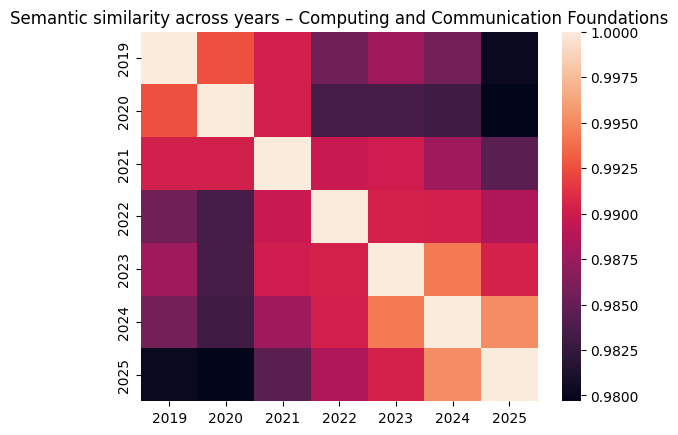

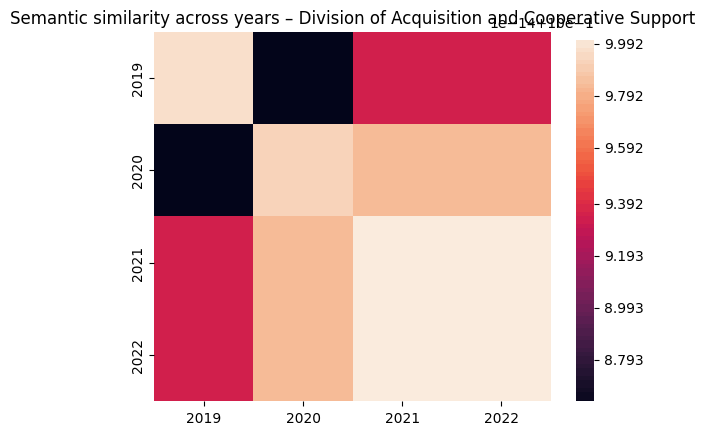

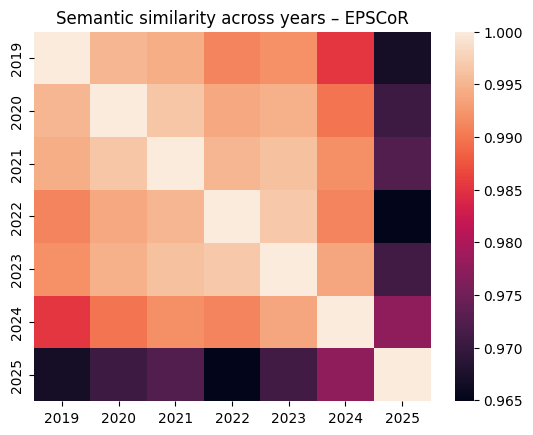

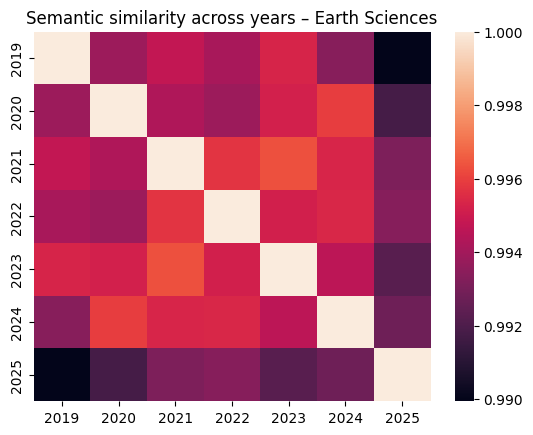

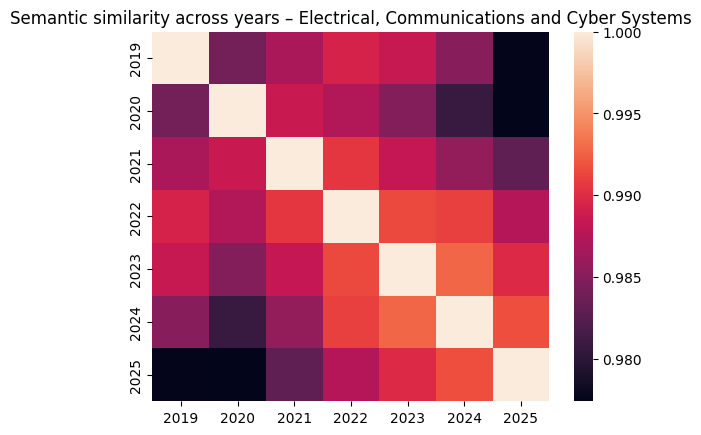

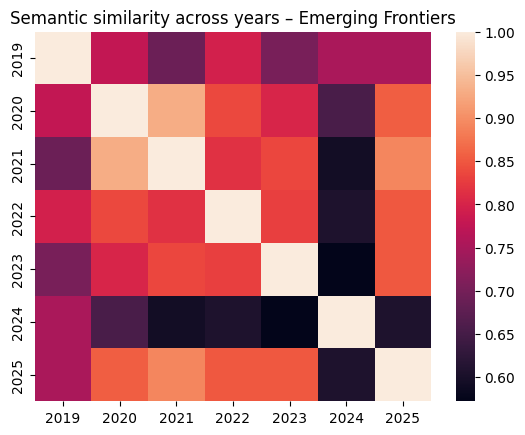

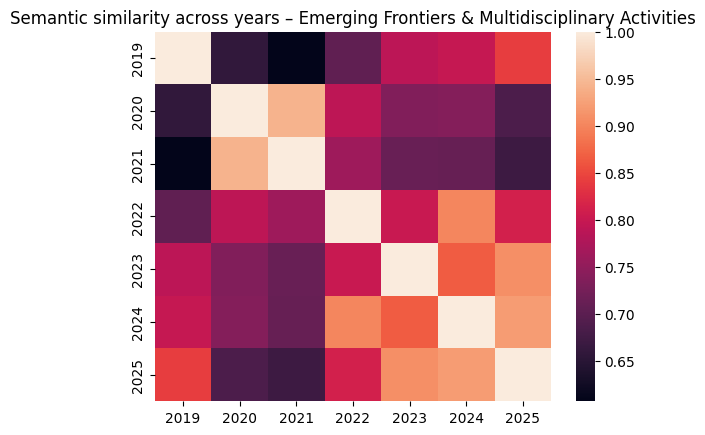

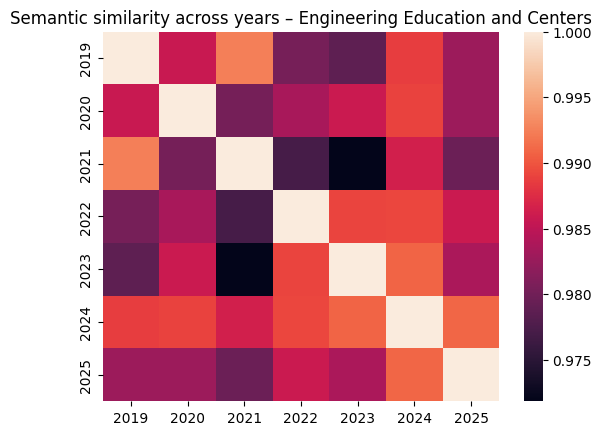

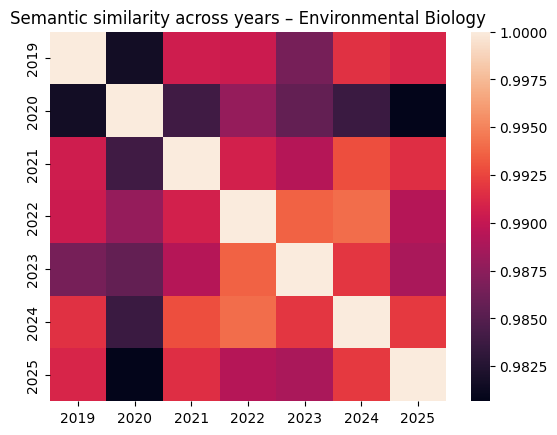

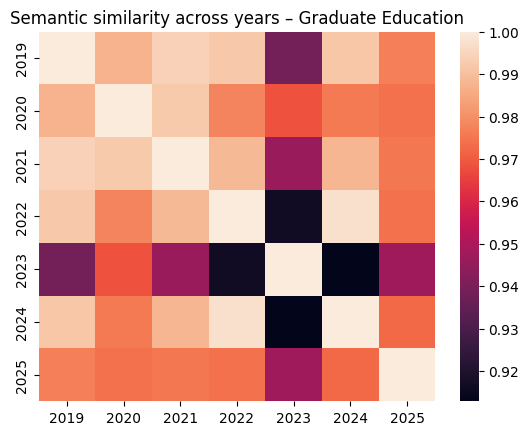

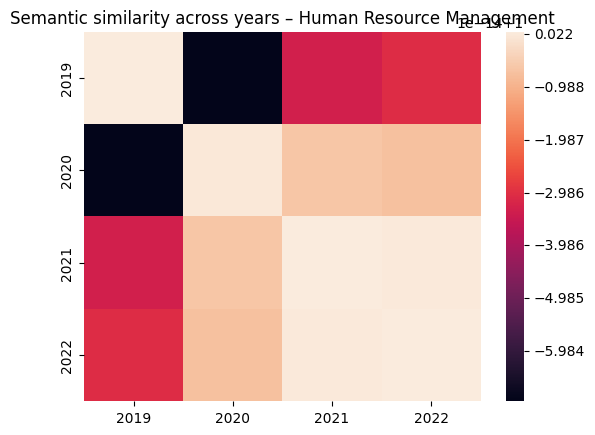

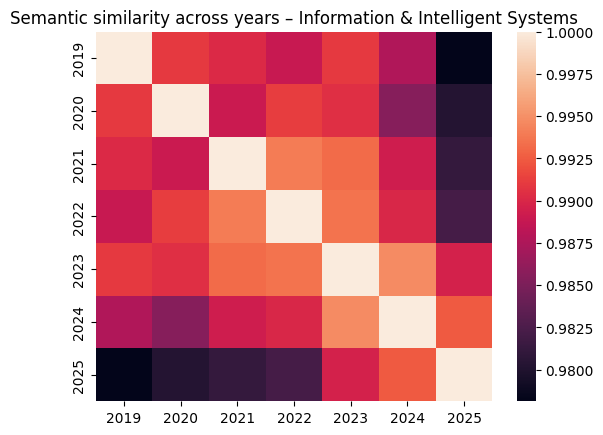

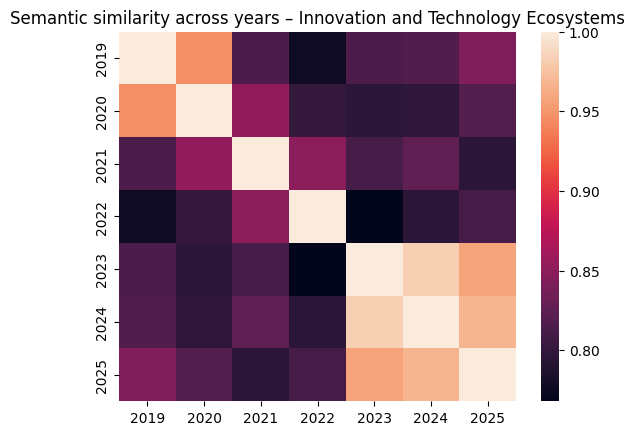

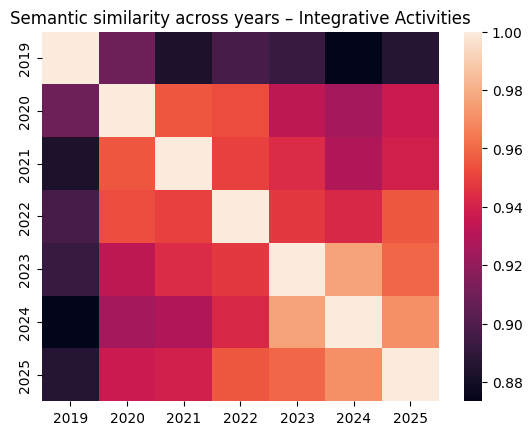

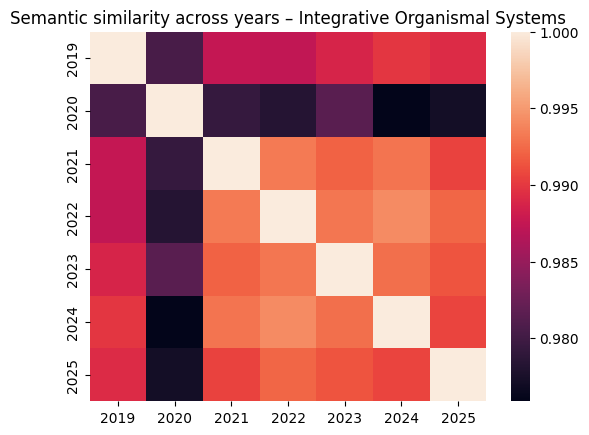

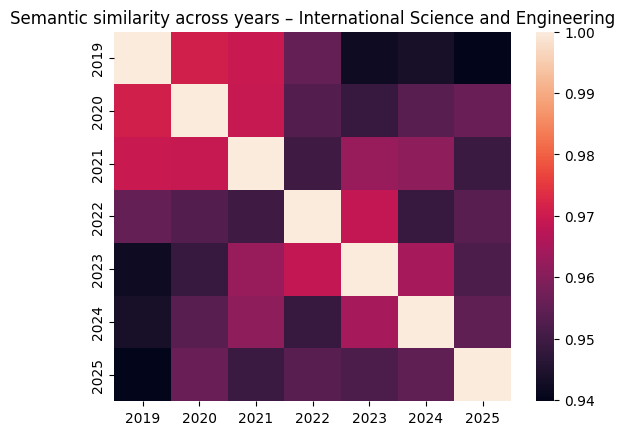

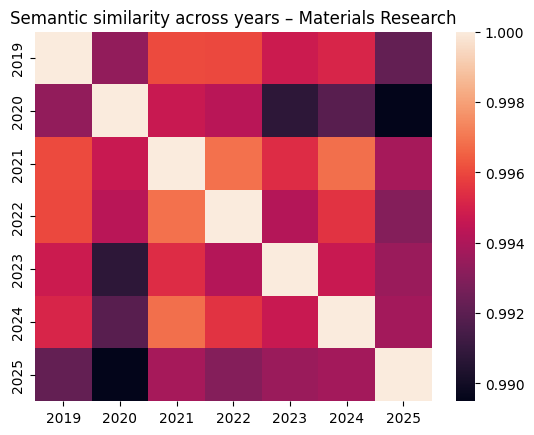

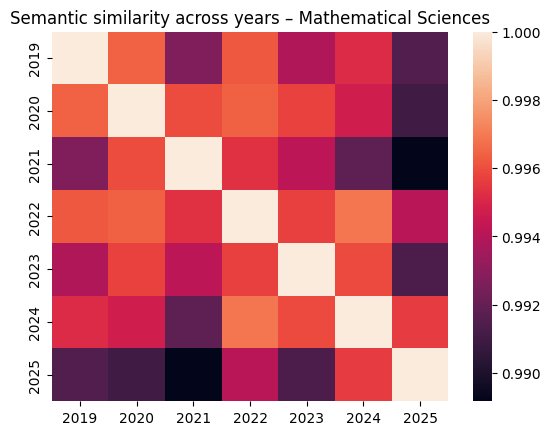

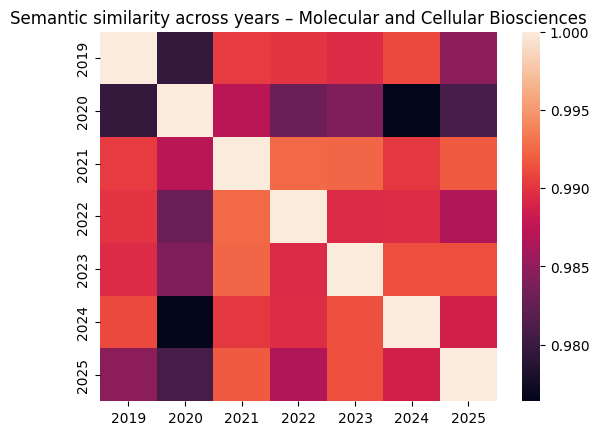

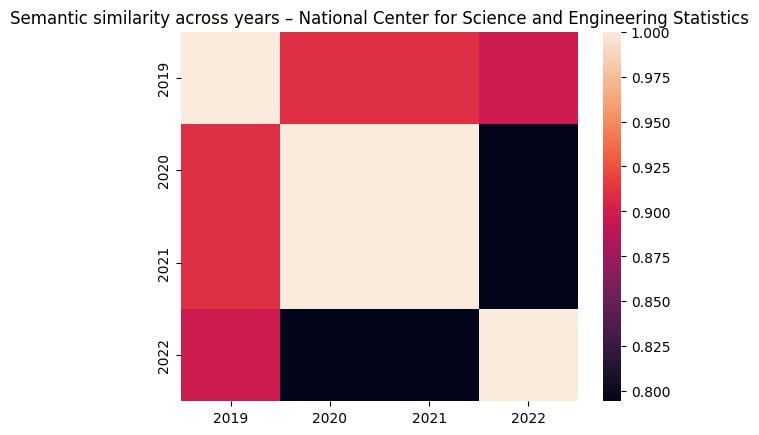

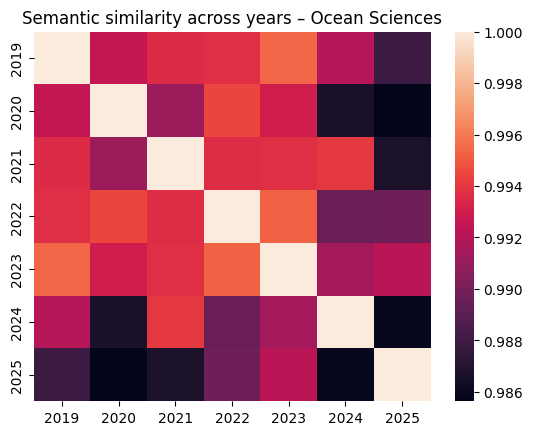

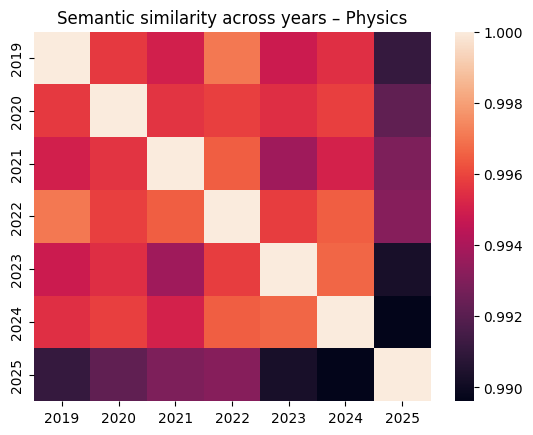

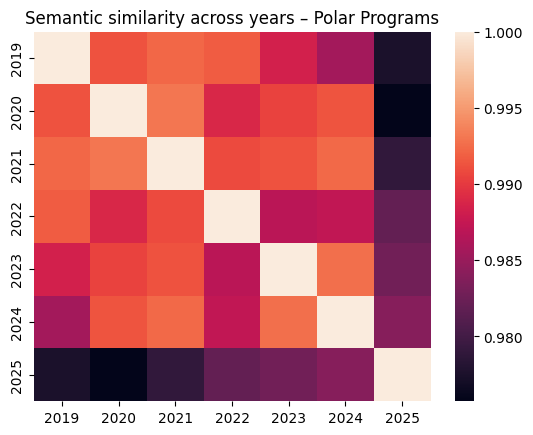

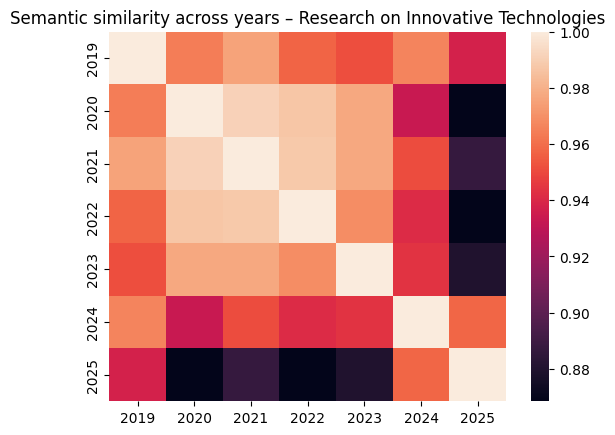

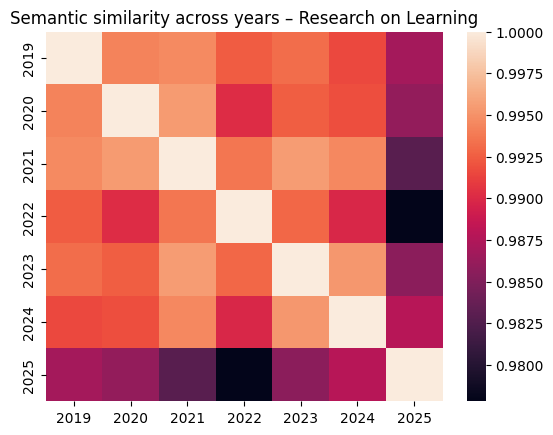

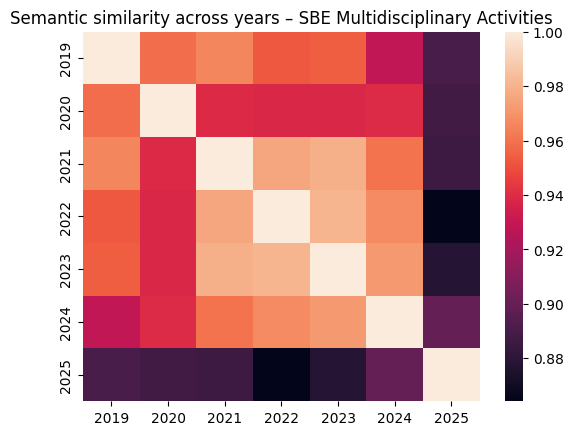

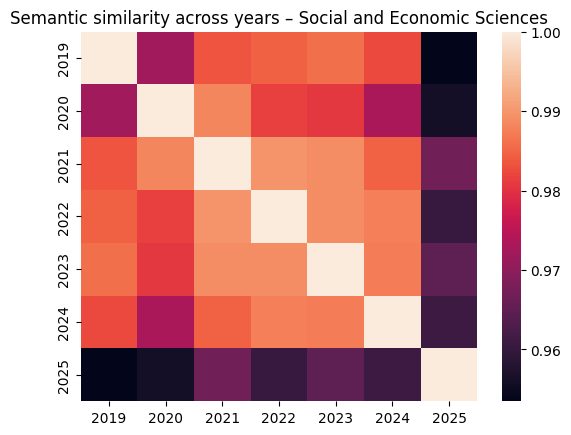

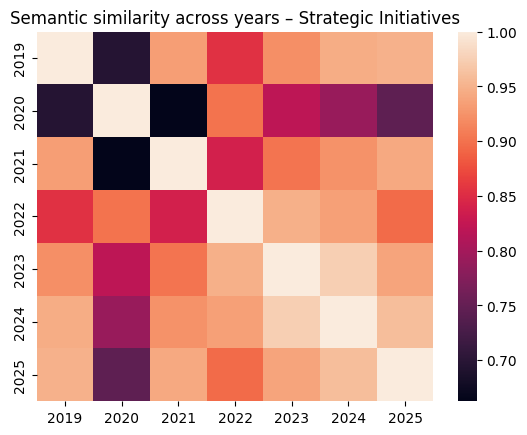

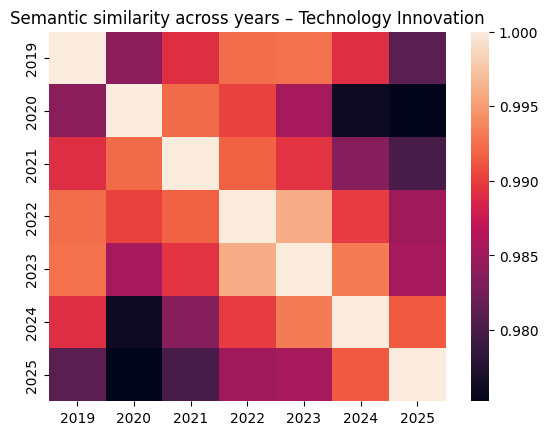

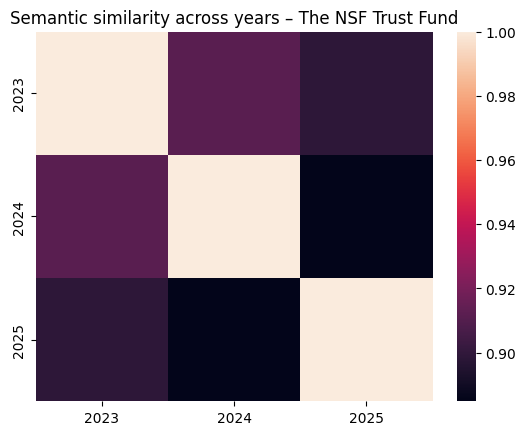

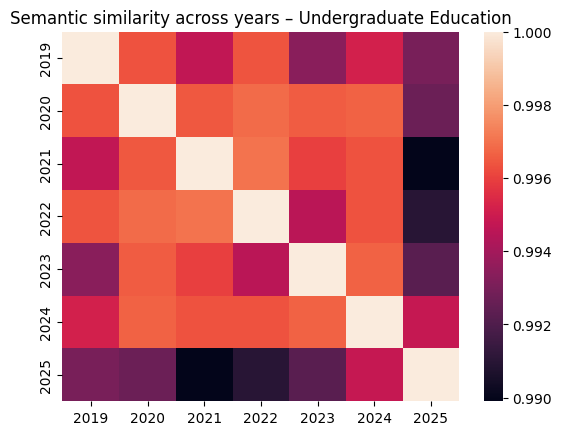

In [10]:
# Number of distinct years per division
years_per_div = (
    df.groupby("division_name")["year"]
      .nunique()
)

# Number of embeddings per division
embeddings_per_div = (
    df.groupby("division_name")["embedding"]
      .size()
)

# Divisions with at least 2 years AND at least 20 embeddings total
mask = (years_per_div >= 2) & (embeddings_per_div >= 20)
eligible_divisions = years_per_div.index[mask].tolist()
print("Divisions with ≥2 years and ≥20 embeddings:", eligible_divisions)

for div in eligible_divisions:
    div_df = df[df["division_name"] == div]

    # build centroids per year
    centroids = (
        div_df.groupby("year")["embedding"]
              .apply(lambda x: np.mean(np.stack(x.values), axis=0))
              .to_dict()
    )

    years = sorted(centroids.keys())
    if len(years) < 2:
        print(f"Skipping {div}: only {len(years)} year(s)")
        continue

    M = np.zeros((len(years), len(years)))
    for i, y1 in enumerate(years):
        for j, y2 in enumerate(years):
            M[i, j] = cos_sim(centroids[y1], centroids[y2])

    sns.heatmap(M, xticklabels=years, yticklabels=years)
    plt.title(f"Semantic similarity across years – {div}")
    plt.show()

In [11]:
# compute pairwise cosine similarity between previous years and 2025
def division_year_centroid(df, division):
    sub = df[df.division_name == division]
    return sub.groupby("year")["embedding"].apply(lambda x: np.stack(x).mean(axis=0))
    
# Compare all years to 2025
from sentence_transformers.util import cos_sim

for year, emb in centroids.items():
    print(year, cos_sim(emb, centroids[2025]).item())

2019 0.9930140182198188
2020 0.9926609392709336
2021 0.9898986113460332
2022 0.9909704246405984
2023 0.9922428108491581
2024 0.9948201525802973
2025 1.0000000000000002


In [12]:
# Put together a bayesian change-point model, to see if we can detect 
# a year where vocabulary in sucessful models changed

# Turn embedding column back to arrays
df["embedding_array"] = df["embedding"].apply(lambda x: np.array(x))

# Mean embedding per year
year_means = (
    df.groupby("year")["embedding_array"]
      .apply(lambda xs: np.vstack(xs).mean(axis=0))
)

# Baseline: mean of all years before 2025
pre_mask = year_means.index < 2025
baseline_vec = np.vstack(year_means[pre_mask].values).mean(axis=0)

def cosine_dist(a, b):
    # 1 - cosine similarity
    return cosine(a, b)

# Semantic drift per year relative to baseline
year_drift = year_means.apply(lambda v: cosine_dist(v, baseline_vec))

# Put into a convenient DataFrame
drift_df = pd.DataFrame({
    "year": year_drift.index.values,
    "drift": year_drift.values,
}).sort_values("year")
drift_df

,year,drift
0,2019,0.001250
1,2020,0.002856
2,2021,0.001100
3,2022,0.000409
4,2023,0.000770
5,2024,0.002104
6,2025,0.007662


In [13]:
# Bayesian change-point model with PyMC
years = drift_df["year"].values
y = drift_df["drift"].values

year_min, year_max = years.min(), years.max()

with pm.Model() as cp_model:
    # Change-point year τ (integer between min and max)
    tau = pm.DiscreteUniform("tau", lower=year_min, upper=year_max)

    mu_pre = pm.Normal("mu_pre", mu=0.0, sigma=1.0)
    mu_post = pm.Normal("mu_post", mu=0.0, sigma=1.0)
    sigma = pm.HalfNormal("sigma", sigma=1.0)

    # For each observed year, pick mu_pre or mu_post based on tau
    mu_t = pm.math.switch(years < tau, mu_pre, mu_post)

    y_obs = pm.Normal("y_obs", mu=mu_t, sigma=sigma, observed=y)

    cp_trace = pm.sample(
        draws=2000,
        tune=2000,
        target_accept=0.9,
        chains=4,
        random_seed=42,
    )

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_pre, mu_post, sigma]


/Users/rileymorrison/CAPP/bayes/NSF/.venv/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


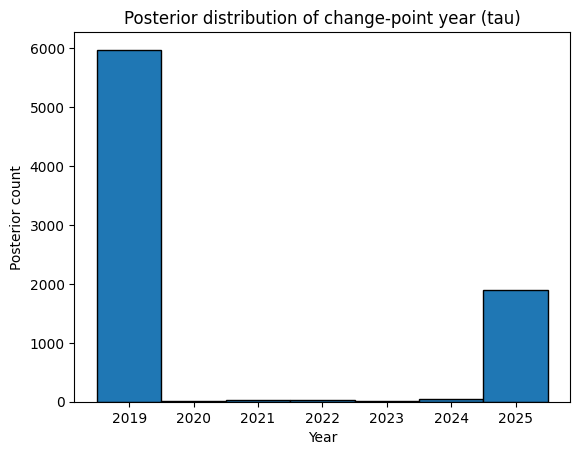

In [14]:
import matplotlib.pyplot as plt
import numpy as np

tau_vals = cp_trace.posterior['tau'].values.flatten()

plt.hist(tau_vals, bins=np.arange(2019, 2027)-0.5, edgecolor='black')
plt.xticks(range(2019, 2026))
plt.title("Posterior distribution of change-point year (tau)")
plt.xlabel("Year")
plt.ylabel("Posterior count")
plt.show()

In [15]:
# Now let's only look at the programs where we saw the most interesting 2025 changes
target_divisions = [
    "EPSCoR",
    "Physics",
    "Social and Economic Sciences",
    "Chemical, Bioengineering, Environmental, and Transport Systems",
    "Polar Programs",
]

# Keep only the divisions we care about
df_sub = df[df["division_name"].isin(target_divisions)].copy()

# Turn embedding column back to arrays
df_sub["embedding_array"] = df_sub["embedding"].apply(lambda x: np.array(x))

# Mean embedding per *year* across the 4 programs (pooled)
year_means = (
    df_sub.groupby("year")["embedding_array"]
          .apply(lambda xs: np.vstack(xs).mean(axis=0))
)

# Baseline: mean of all years before 2025 (within these 4 programs only)
pre_mask = year_means.index < 2025
baseline_vec = np.vstack(year_means[pre_mask].values).mean(axis=0)

def cosine_dist(a, b):
    return cosine(a, b)  # 1 - cosine similarity

# Semantic drift per year relative to baseline
year_drift = year_means.apply(lambda v: cosine_dist(v, baseline_vec))

# Put into a convenient DataFrame
drift_df = (
    pd.DataFrame({
        "year": year_drift.index.values,
        "drift": year_drift.values,
    })
    .sort_values("year")
)

drift_df

,year,drift
0,2019,0.002648
1,2020,0.009573
2,2021,0.002821
3,2022,0.001922
4,2023,0.002030
5,2024,0.003847
6,2025,0.025814


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_pre, mu_post, sigma]


/Users/rileymorrison/CAPP/bayes/NSF/.venv/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 7 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


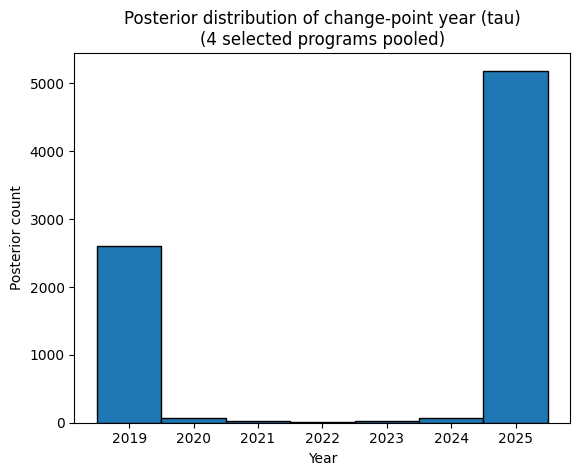

In [16]:
years = drift_df["year"].values
y = drift_df["drift"].values

year_min, year_max = years.min(), years.max()

with pm.Model() as cp_model:
    tau = pm.DiscreteUniform("tau", lower=year_min, upper=year_max)

    mu_pre = pm.Normal("mu_pre", mu=0.0, sigma=1.0)
    mu_post = pm.Normal("mu_post", mu=0.0, sigma=1.0)
    sigma = pm.HalfNormal("sigma", sigma=1.0)

    mu_t = pm.math.switch(years < tau, mu_pre, mu_post)

    y_obs = pm.Normal("y_obs", mu=mu_t, sigma=sigma, observed=y)

    cp_trace = pm.sample(
        draws=2000,
        tune=2000,
        target_accept=0.9,
        chains=4,
        random_seed=42,
    )

tau_vals = cp_trace.posterior['tau'].values.flatten()

plt.hist(tau_vals, bins=np.arange(2019, 2027)-0.5, edgecolor='black')
plt.xticks(range(2019, 2026))
plt.title("Posterior distribution of change-point year (tau)\n(4 selected programs pooled)")
plt.xlabel("Year")
plt.ylabel("Posterior count")
plt.show()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_pre, mu_post, sigma]


/Users/rileymorrison/CAPP/bayes/NSF/.venv/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.


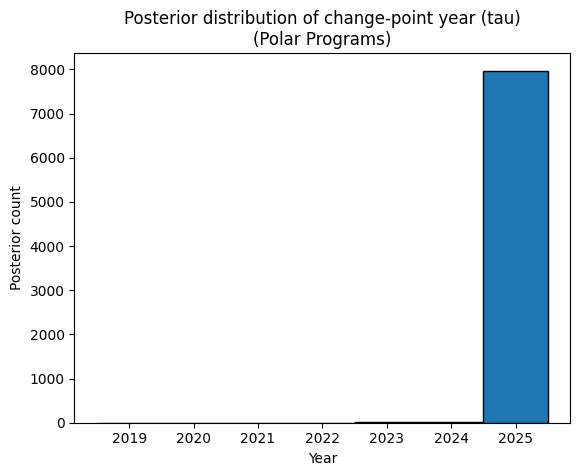

In [17]:
# Now let's only look at the programs where we saw the most interesting 2025 changes
target_divisions = [
    "Polar Programs",
]

# Keep only the divisions we care about
df_sub = df[df["division_name"].isin(target_divisions)].copy()

# Turn embedding column back to arrays
df_sub["embedding_array"] = df_sub["embedding"].apply(lambda x: np.array(x))

# Mean embedding per *year* across the 4 programs (pooled)
year_means = (
    df_sub.groupby("year")["embedding_array"]
          .apply(lambda xs: np.vstack(xs).mean(axis=0))
)

# Baseline: mean of all years before 2025 (within these 4 programs only)
pre_mask = year_means.index < 2025
baseline_vec = np.vstack(year_means[pre_mask].values).mean(axis=0)

def cosine_dist(a, b):
    return cosine(a, b)  # 1 - cosine similarity

# Semantic drift per year relative to baseline
year_drift = year_means.apply(lambda v: cosine_dist(v, baseline_vec))

# Put into a convenient DataFrame
drift_df = (
    pd.DataFrame({
        "year": year_drift.index.values,
        "drift": year_drift.values,
    })
    .sort_values("year")
)

drift_df

years = drift_df["year"].values
y = drift_df["drift"].values

year_min, year_max = years.min(), years.max()

with pm.Model() as cp_model:
    tau = pm.DiscreteUniform("tau", lower=year_min, upper=year_max)

    mu_pre = pm.Normal("mu_pre", mu=0.0, sigma=1.0)
    mu_post = pm.Normal("mu_post", mu=0.0, sigma=1.0)
    sigma = pm.HalfNormal("sigma", sigma=1.0)

    mu_t = pm.math.switch(years < tau, mu_pre, mu_post)

    y_obs = pm.Normal("y_obs", mu=mu_t, sigma=sigma, observed=y)

    cp_trace = pm.sample(
        draws=2000,
        tune=2000,
        target_accept=0.9,
        chains=4,
        random_seed=42,
    )

tau_vals = cp_trace.posterior['tau'].values.flatten()

plt.hist(tau_vals, bins=np.arange(2019, 2027)-0.5, edgecolor='black')
plt.xticks(range(2019, 2026))
plt.title("Posterior distribution of change-point year (tau)\n(Polar Programs)")
plt.xlabel("Year")
plt.ylabel("Posterior count")
plt.show()